# transfer learning + explainable artificial inteligence(CAM)
- toc:true

In [ ]:
import torch 
import torchvision
from fastai.vision.all import * 

## transfer learning
- 누군가가 만들어 놓은 모델의 구조를 사용하는 것
- fine_tune을 사용하면 전이학습이 되어 학습시간이 줄어들음
- lrnr.fit을 사용하면 그냥 학습을 시키는 것

### 데이터 준비

In [ ]:
path = untar_data(URLs.CIFAR)

In [ ]:
path.ls() # path에는 labels라는 텍스트 파일과 test,train이라는 폴더가 있음

(#3) [Path('/root/.fastai/data/cifar10/labels.txt'),Path('/root/.fastai/data/cifar10/test'),Path('/root/.fastai/data/cifar10/train')]

In [ ]:
!ls /root/.fastai/data/cifar10/train

airplane  automobile  bird  cat  deer  dog  frog  horse  ship  truck


- train 폴더 안에는 위위와 같은 폴더들이 있음 
- 각 폴더에는 이름과 맞는 이미지 파일이 있음 
- 10개의 클래스

- 앞 장에서 만든 CNN Architecture를 사용하면 정확도가 매우 떨어짐
  - 학습과정은 패스했음
- 더 복잡하고 정교한 모델을 만들어야 함 $\to$ transfer learning 사용

### 모델 만들기
- ResNet의 weights를 그대로 가져와 학습에 사용

#### 모델 가져오는 방법 1

In [ ]:
dls = ImageDataLoaders.from_folder(path,train='train',valid='test')

In [ ]:
_x, _y = dls.one_batch()
_x.shape, _y.shape

(torch.Size([64, 3, 32, 32]), torch.Size([64]))

- x의 배치크기는 64(= 하나의 배치에 64개의 데이터(이미지)가 있음을 의미), 채널은 3(컬러 이미지), size는 32 x 32이다.
- y는 x의 레이블로 64개의 이미지가 있으므로 64개의 값이 y에 저장됨

In [ ]:
_y

TensorCategory([5, 2, 8, 6, 8, 5, 1, 2, 1, 0, 4, 8, 7, 7, 0, 4, 2, 6, 8, 6, 6,
                2, 0, 7, 1, 9, 5, 4, 3, 6, 4, 9, 6, 4, 3, 7, 3, 9, 3, 6, 5, 3,
                6, 6, 6, 8, 6, 3, 5, 3, 5, 9, 5, 3, 9, 0, 7, 3, 6, 6, 7, 7, 8,
                9], device='cuda:0')

In [ ]:
#collapse_output
net = torchvision.models.resnet18(weights=torchvision.models.resnet.ResNet18_Weights.IMAGENET1K_V1)
net

- 마지막 출력층을 확인해보면 1000개를 출력함
- 하지만 우리는 10개의 클래스를 구분하는 모델을 만들 것이므로 1000을 10으로 바꿔야 함

In [ ]:
net.fc = torch.nn.Linear(in_features=512, out_features=10) 

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()

lrnr = Learner(dls, net, loss_fn, metrics = accuracy)

In [ ]:
lrnr.fit(10)

epoch,train_loss,valid_loss,accuracy,time
0,0.804860,0.821773,0.724900,01:15
1,0.640089,0.679617,0.773700,01:09
2,0.519974,0.647182,0.783100,01:05
3,0.405207,0.564490,0.811400,01:14
4,0.344672,0.683868,0.783300,01:05
5,0.269288,0.737170,0.785200,01:12
6,0.272949,0.788109,0.769800,01:12
7,0.188042,0.690548,0.808600,01:10
8,0.175680,0.736700,0.800500,01:09
9,0.151409,0.821169,0.795500,01:06


#### 모델 가져오는 방법 2
- overview에서 fastai를 사용한 방법 (fastai로만 모델을 구현)

In [ ]:
path = untar_data(URLs.PETS)/'images'

files= get_image_files(path)

def label_func(fname):
    if fname[0].isupper():
        return 'cat'
    else:
        return 'dog'

dls = ImageDataLoaders.from_name_func(path,files,label_func,item_tfms=Resize(512))

In [ ]:
lrnr = vision_learner(dls,resnet34,metrics=accuracy) 

In [ ]:
lrnr.fine_tune(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.175012,0.026964,0.989851,01:54


epoch,train_loss,valid_loss,accuracy,time
0,0.047284,0.022501,0.994587,02:29


- 아래의 코드를 사용하면 network의 구조를 볼 수 있음
``` python
lrnr.model()
```

## 데이터 확인

In [ ]:
# 위의 코드(fastai로 transfer learning) 똑같음
path = untar_data(URLs.PETS)/'images'

files= get_image_files(path)

def label_func(fname):
    if fname[0].isupper():
        return 'cat'
    else:
        return 'dog'

dls = ImageDataLoaders.from_name_func(path,files,label_func,item_tfms=Resize(512))

In [ ]:
path.ls()

(#7393) [Path('/root/.fastai/data/oxford-iiit-pet/images/havanese_36.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_7.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Abyssinian_97.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/chihuahua_135.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/keeshond_110.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/yorkshire_terrier_54.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/wheaten_terrier_11.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/British_Shorthair_62.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/german_shorthaired_171.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/havanese_84.jpg')...]

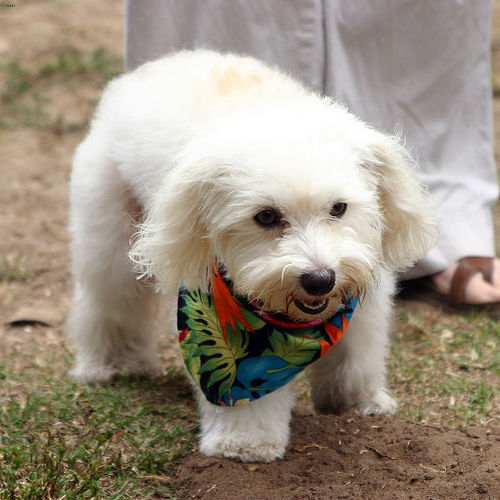

In [ ]:
ximg = PILImage.create('/root/.fastai/data/oxford-iiit-pet/images/havanese_36.jpg')
ximg

In [ ]:
x= first(dls.test_dl([ximg]))[0]
x.shape # 위 이미지의 shape

torch.Size([1, 3, 512, 512])

- torch.nn.AdaptiveAvgPool2d()
  - pooling을 평균으로 하는 것으로 output_size = 1이라면 채널당 하나의 값을 출력해줌
  - 위의 이미지는 채널이 3개이므로 이미지 하나당 3개의 값을 출력

In [ ]:
ap = torch.nn.AdaptiveAvgPool2d(output_size=1) # output size가 1이라는 것은 (1x1)로 출력하겠다는 뜻
# 만약 2이면 출력이 (2 x 2) 즉 채널당 4개의 값이 나오는 것임
ap(x)

TensorImage([[[[0.6086]],

              [[0.5648]],

              [[0.5058]]]], device='cuda:0')

### 이미지 차원의 순서 변경(torch.einsum)
- 데이터 로더를 사용해 불러온 이미지 데이트의 차원을 확인해보면 [1, 3, 512, 512]이다. 이는 배치사이즈, 채널, 높이, 너비 순으로 되어있는 것임
- 이러한 데이터를 높이, 너비, 채널 순으로 바꾸고 싶음 $\to$ torch.einsum()사용
``` python
torch.einsum('ij,jk->ik',tensor1, tensor2) # 크기가 i x j인 tensor1과 j x k인 tensor2의 행렬 곱을 해줌
```
- torch.Size([1, 3, 512, 512]) $\to$ torch.Size([512, 512, 3]) 형태로 만들고 싶음

`→` tensor의 차원을 변경하거나 계산을 할 때에는 torch.einsum()함수를 사용하면 좋음

In [ ]:
x_new = torch.einsum('ocij -> ijc',x.to('cpu'))

- plt는 높이 x 너비 x 채널 순으로 데이터가 입력되길 기대
- 만약 x 즉, 채널 x 높이 x 너비 순으로 되어있는 데이터를 입력하면 에러가 발생함

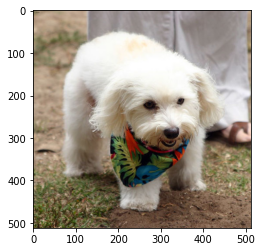

In [ ]:
plt.imshow(x_new)

## CAM 구현
- CAM(Class Activation Mapping): CNN의 판단근거를 시각화하는 기술

### 네트워크 선택

In [ ]:
lrnr = vision_learner(dls,resnet34,metrics=accuracy) 

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
lrnr.fine_tune(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.208073,0.010794,0.995940,01:55


epoch,train_loss,valid_loss,accuracy,time
0,0.047890,0.002702,0.998647,02:25


- lrnr.model 함수를 사용하면 resnet34의 구조를 볼 수 있음
- 구조를 확인해보면 resnet34는 두 개의 모델이 합쳐져 있음
- 첫 번째 모델은 그대로 사용하고 두 번째 모델만 약간 수정하여 사용해보자

### 네트워크 살짝 변형

In [ ]:
net1 = lrnr.model[0]
net2 = lrnr.model[1]

In [ ]:
net1.to('cpu')
net2.to('cpu')

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=2, bias=False)
)

- BatchNorm1d과 Dropout, ReLU 층은 파라미터 개수에 변화를 주지 않음
- pooling층과 Linear층을 주목해야 함

In [ ]:
_X, _y = dls.one_batch() 

In [ ]:
_X = _X.to('cpu')
# net1(_X).shape #torch.Size([64, 512, 16, 16]) 이러한 형태로 출력됨

In [ ]:
net2= torch.nn.Sequential(
    torch.nn.AdaptiveAvgPool2d(output_size=1), # (64,512,16,16) -> (64,512,1,1) 
    torch.nn.Flatten(), # (64,512,1,1) -> (64,512) 
    torch.nn.Linear(512,2,bias=False) # (64,512) -> (64,2) 
)

In [ ]:
net = torch.nn.Sequential(
    net1,
    net2
)

lrnr2= Learner(dls,net,metrics=accuracy)

lrnr2.fine_tune(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.232032,1.522452,0.836265,02:25


epoch,train_loss,valid_loss,accuracy,time
0,0.134071,0.816453,0.830176,02:24
1,0.138622,0.150047,0.936401,02:25
2,0.095163,0.100338,0.960081,02:24
3,0.051146,0.039767,0.984438,02:28
4,0.024118,0.044908,0.982409,02:30


### average pooling과 선형변환층 순서 변경

`-` net2의 순서 바꾸기 전 전체 네트워크: 

$$\underset{(1,3,512,512)}{\boldsymbol x} \overset{net_1}{\to} \left( \underset{(1,512,16,16)}{\tilde{\boldsymbol x}} \overset{ap}{\to} \underset{(1,512,1,1)}{{\boldsymbol \sharp}}\overset{flatten}{\to} \underset{(1,512)}{{\boldsymbol \sharp}}\overset{linear}{\to} \underset{(1,2)}{\hat{\boldsymbol y}}\right) = [-9.0358,  9.0926]$$

- 위의 수식을 아래의 수식으로 바꾸고 싶음
  - 순서만 바꾸는 것임 -> 결과는 똑같음

$$\underset{(1,3,224,224)}{\boldsymbol x} \overset{net_1}{\to} \left( \underset{(1,512,16,16)}{\tilde{\boldsymbol x}} \overset{linear}{\to} \underset{(1,2,16,16)}{{\bf why}}\overset{ap}{\to} \underset{(1,2,1,1)}{{\boldsymbol \sharp}}\overset{flatten}{\to} \underset{(1,2)}{\hat{\boldsymbol y}}\right) = [−9.0358,9.0926]$$

- 여기서 주목해야 하는 것은 $why$
- $why$의 값들을 평균을 내고 이 값을 선형변환하여 하나의 값을 만듦 [−9.0358 or 9.0926]
- $why$의 tensor를 확인해보자!


- 바꾸기 전 net2의 구조 중 일부분 (배치를 넣는 것이 아니라 하나의 이미지를 net에 넣을때임)
  - X = net1(x)
    - X.shape = (1, 512, 16, 16)
  - XX = torch.nn.AdaptiveAvgPool2d(X) 
    - XX.shape =(1, 512, 1, 1)
  - XXX= torch.nn.Flatten(XX)
    - XXX.shape -> (1,512) 
  - XXX @ net2[2].weight $\to$ shape(1, 2)
    - net2[2].weight.shape -> (512, 2)


In [ ]:
ximg = PILImage.create('/root/.fastai/data/oxford-iiit-pet/images/havanese_36.jpg')
x = first(dls.test_dl([ximg]))[0]

In [ ]:
# 위의 정리된 것들을 보면
# net2[2].weight의 크기는 (512, 2)
# net1(x)의 크기는 (1, 512, 16, 16)
# why의 크기를 (1, 2, 16, 16)으로 만들고 싶음
why = torch.einsum('cb,abij->acij',
                   net2[2].weight,#(512, 2)
                   net1(x) # (1, 512, 16, 16)
                   )
why.shape

torch.Size([1, 2, 16, 16])

In [ ]:
# net2[0]은 avg pooling layer -> 높이와 폭을 0으로 만듦
# (1, 2, 16, 16) -> (1, 2, 1, 1)
net2[0](why)

TensorImage([[[[-7.2395]],

              [[ 7.5647]]]], device='cuda:0', grad_fn=<AliasBackward0>)

#### why의 tensor 확인

##### why의 첫번째 값 확인
- tensor의 평균 -9.0358
- 해당 tensor의 평균이 크다면 고양이라고 판단을 함
  - 하지만 이번 예시에서는 평균이 음수가 나옴 -> 해당 값이 작으면 작을수록 고양이가 아니라고 생각하는 근거가 됨
- 그러므로 해당 tensor에서 엄청 작은 값들은 고양이가 아니라고 판단하는 근거가 되는 점들임

In [ ]:
why[0,0,:,:].to(torch.int64)

TensorImage([[  -1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
                 0,    0,    0,    0,    0],
             [  -1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
                 0,    0,    0,    0,    0],
             [  -1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
                 0,    0,    0,    0,    0],
             [  -1,    0,    1,    1,    0,    1,    1,    1,    1,    0,    0,
                 0,    0,    0,    0,    0],
             [  -1,    0,    0,    0,    1,    1,    0,    0,   -1,   -2,   -2,
                -1,    0,    2,    2,    1],
             [   0,    0,    0,    0,    0,    0,   -2,  -10,  -17,  -18,  -17,
               -14,   -7,    2,    5,    1],
             [  -1,    0,    0,    0,    0,    0,   -7,  -26,  -45,  -43,  -38,
               -34,  -16,    0,    3,    0],
             [  -1,    0,    0,   -1,   -2,   -3,  -10,  -32,  -56,  -58,  -50,
               -43,  -22,   -2,    1,    1],


##### why의 두 번째 값 확인
- tensor의 평균 9.0926 
- 해당 tensor는 강아지라고 판단하는 tensor라고 생각하면 됨
- 그러므로 해당 tensor에서 엄청 작은 값들은 고양이가 아니라고 판단하는 근거가 되는 점들임

In [ ]:
why[0,1,:,:].to(torch.int64)

TensorImage([[ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1],
             [ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
             [ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
             [ 2,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
             [ 1,  0,  0,  0,  0,  0,  0,  0,  1,  2,  2,  2,  0, -1, -1,  0],
             [ 0,  0,  0,  0,  0,  0,  2, 10, 16, 18, 17, 14,  7, -1, -3, -1],
             [ 1,  1,  0,  0,  0,  0,  6, 25, 43, 42, 37, 32, 16,  1, -2,  0],
             [ 1,  0,  0,  1,  2,  3, 10, 32, 55, 58, 50, 42, 21,  3,  0,  0],
             [ 0, -1,  0,  6, 13, 12, 11, 24, 44, 65, 69, 49, 20,  1, -1, -1],
             [-7, -8, -1,  9, 18, 17, 10, 13, 33, 72, 97, 65, 22,  0,  0,  0],
             [-9, -9, -2,  5, 12, 13,  7,  5, 22, 58, 81, 62, 21,  1,  0,  1],
             [-6, -6, -1,  1,  2,  4,  3,  1, 11, 31, 43, 34, 14,  1,  1,  2],
             [ 0,  0,  0,  0,  0,  0,  1,  0,  1,  7

### 근거를 바탕으로 시각화

- why의 값과 이미지를 동시에 출력한다면 그림의 어떠한 부분을 보고 강아지라고 판단을 한 것인지 알 수 있음

In [ ]:
why_cat = why[0,0,:,:] # 해당 tensor의 값이 작으면 작을 수록 고양이가 아니라고 판단하는 근거가 됨
why_dog = why[0,1,:,:] # 해당 tensor의 값이 크면 클수록 강아지라고 판단하는 근거가 됨

- 밑에서 cmap을 magma로 지정하였는 이는 값이 작은 부분은 검정색 큰 부분은 노란색으로 표시함
  - 검정 -> 보라 -> 빨강 -> 노랑 
- 이를 해석하면 why_cat에서 값이 가장 작은 부분, 즉 검정색이 고양이가 아니라고 판단함
- why_dog에서는 값이 가장 큰 부분, 즉 노란색이 강아지라고 판단하는 영역을 표시함


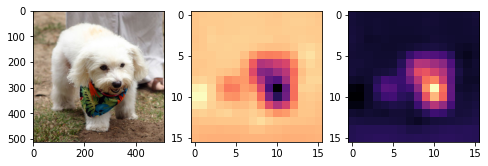

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(8,4))
ax[0].imshow(torch.einsum('ocij -> ijc',dls.decode((x,))[0]).to("cpu"))
ax[1].imshow(why_cat.to("cpu").detach(),cmap='magma')
ax[2].imshow(why_dog.to("cpu").detach(),cmap='magma')

- why의 크기 조절

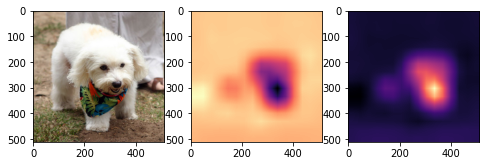

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(8,4))
ax[0].imshow(torch.einsum('ocij -> ijc',dls.decode((x,))[0]).to("cpu"))
ax[1].imshow(why_cat.to("cpu").detach(),cmap='magma',extent=(0,511,511,0),interpolation='bilinear')
ax[2].imshow(why_dog.to("cpu").detach(),cmap='magma',extent=(0,511,511,0),interpolation='bilinear')

- 크기조절 후 겹쳐그리기

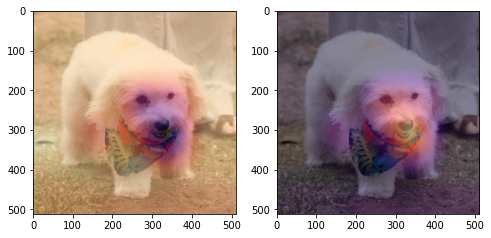

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
ax[0].imshow(torch.einsum('ocij -> ijc',dls.decode((x,))[0]).to("cpu"))
ax[0].imshow(why_cat.to("cpu").detach(),cmap='magma',extent=(0,511,511,0),interpolation='bilinear',alpha=0.5)
ax[1].imshow(torch.einsum('ocij -> ijc',dls.decode((x,))[0]).to("cpu"))
ax[1].imshow(why_dog.to("cpu").detach(),cmap='magma',extent=(0,511,511,0),interpolation='bilinear',alpha=0.5)

##### 정확도도 함께 표시하기

In [ ]:
# why값을 확률로 출력하기
sftmax=torch.nn.Softmax(dim=1)
sftmax(net(x))
catprob, dogprob = sftmax(net(x))[0,0].item(), sftmax(net(x))[0,1].item()

Text(0.5, 1.0, 'dogprob=1.000000')

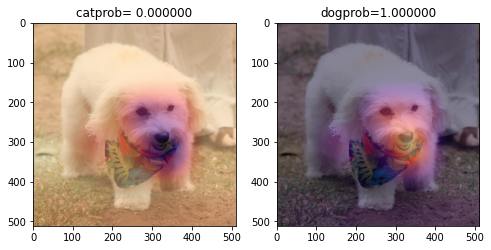

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
ax[0].imshow(torch.einsum('ocij -> ijc',dls.decode((x,))[0]).to("cpu"))
ax[0].imshow(why_cat.to("cpu").detach(),cmap='magma',extent=(0,511,511,0),interpolation='bilinear',alpha=0.5)
ax[0].set_title('catprob= %f' % catprob) 
ax[1].imshow(torch.einsum('ocij -> ijc',dls.decode((x,))[0]).to("cpu"))
ax[1].imshow(why_dog.to("cpu").detach(),cmap='magma',extent=(0,511,511,0),interpolation='bilinear',alpha=0.5)
ax[1].set_title('dogprob=%f' % dogprob)

### CAM 시각화

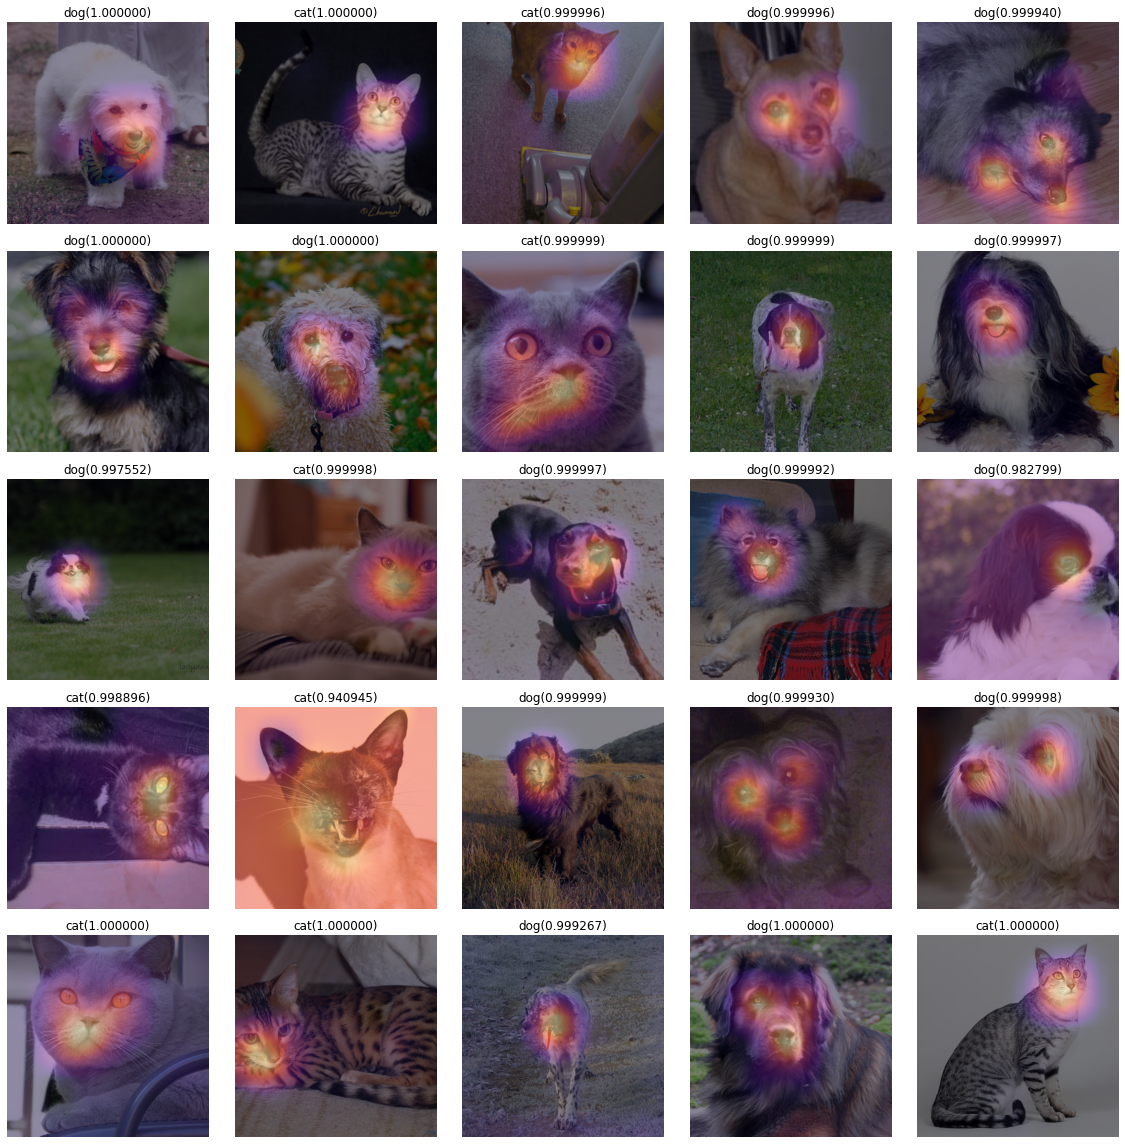

In [ ]:
fig, ax = plt.subplots(5,5) 
k=0 
for i in range(5):
    for j in range(5): 
        x, = first(dls.test_dl([PILImage.create(get_image_files(path)[k])]))
        why = torch.einsum('cb,abij -> acij', net2[2].weight, net1(x))
        why_cat = why[0,0,:,:] 
        why_dog = why[0,1,:,:] 
        catprob, dogprob = sftmax(net(x))[0][0].item(), sftmax(net(x))[0][1].item()
        if catprob>dogprob: 
            dls.train.decode((x,))[0].squeeze().show(ax=ax[i][j])
            ax[i][j].imshow(why_cat.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
            ax[i][j].set_title("cat(%2f)" % catprob)
        else: 
            dls.train.decode((x,))[0].squeeze().show(ax=ax[i][j])
            ax[i][j].imshow(why_dog.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
            ax[i][j].set_title("dog(%2f)" % dogprob)
        k=k+1 
fig.set_figwidth(16)            
fig.set_figheight(16)
fig.tight_layout()